In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "im3"
vol = "vlim"
z_range = "high_z"
key = "lambda"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

15it [00:00, 148.15it/s]

32it [00:00, 153.63it/s]

44it [00:00, 137.95it/s]

60it [00:00, 142.96it/s]

78it [00:00, 151.09it/s]

96it [00:00, 157.62it/s]

114it [00:00, 161.73it/s]

130it [00:00, 149.15it/s]

148it [00:00, 154.71it/s]

164it [00:01, 136.04it/s]

182it [00:01, 145.86it/s]

197it [00:01, 146.58it/s]

215it [00:01, 153.98it/s]

215it [00:01, 151.93it/s]


0it [00:00, ?it/s]

19it [00:00, 182.12it/s]

Number of empty sat catalogs is 0


36it [00:00, 177.41it/s]

55it [00:00, 179.36it/s]

73it [00:00, 179.50it/s]

91it [00:00, 177.93it/s]

106it [00:00, 153.50it/s]

120it [00:00, 130.76it/s]

133it [00:00, 123.98it/s]

146it [00:01, 118.92it/s]

158it [00:01, 116.28it/s]

170it [00:01, 114.61it/s]

184it [00:01, 119.69it/s]

196it [00:01, 111.28it/s]

208it [00:01, 110.14it/s]

215it [00:01, 132.41it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

/home/cz136/project/sa/lib/src/func.py:11: RuntimeWarning: invalid value encountered in true_divide
  raise TypeError
/home/cz136/project/sa/lib/src/func.py:10: RuntimeWarning: invalid value encountered in true_divide
  else:


In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

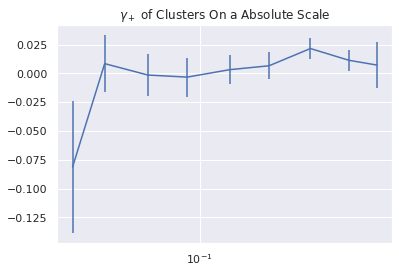

Aggregated xi:
[  0.       1.219   -0.6081   0.1726   0.618   -1.1946  -3.4342 -14.8365
  -7.9504  -1.043 ]
------------------------------------------------------------------------------
Aggregated meanlogr:
[   0.      -56.6991 -245.2916 -342.7496 -465.0764 -731.6474 -780.6979
 -701.2916 -400.183   -35.6676]
------------------------------------------------------------------------------
Aggregated npairs:
[  0.  15.  72. 118. 190. 374. 521. 689. 701. 145.]
------------------------------------------------------------------------------
Mean xi:
[    nan  0.0813 -0.0084  0.0015  0.0033 -0.0032 -0.0066 -0.0215 -0.0113
 -0.0072]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan -3.7799 -3.4068 -2.9047 -2.4478 -1.9563 -1.4985 -1.0178 -0.5709
 -0.246 ]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

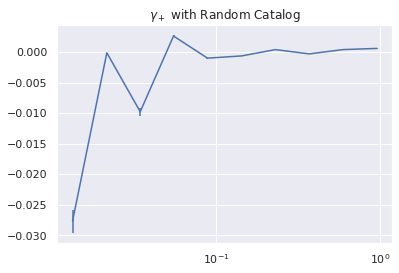

[-0.0277 -0.0001 -0.0097  0.0026 -0.001  -0.0006  0.0004 -0.0003  0.0004
  0.0006]
[ 1.8861e-03  6.8475e-06  6.6462e-04 -1.8021e-04  6.6395e-05  4.1823e-05
 -2.8848e-05  1.8987e-05 -2.8878e-05 -4.2110e-05]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

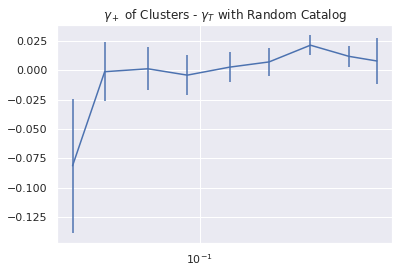

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

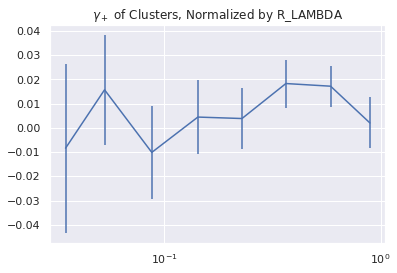

Aggregated xi:
[  0.       0.       0.3436  -1.3185   1.5785  -1.1392  -1.7474 -10.6569
 -13.1276  -0.9896]
------------------------------------------------------------------------------
Aggregated meanlogr:
[   0.        0.     -137.3597 -246.5631 -379.5236 -497.3765 -668.9611
 -586.8207 -405.6591  -54.9266]
------------------------------------------------------------------------------
Aggregated npairs:
[  0.   0.  41.  84. 156. 256. 454. 583. 764. 487.]
------------------------------------------------------------------------------
Mean xi:
[    nan     nan  0.0084 -0.0157  0.0101 -0.0045 -0.0038 -0.0183 -0.0172
 -0.002 ]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan     nan -3.3502 -2.9353 -2.4328 -1.9429 -1.4735 -1.0066 -0.531
 -0.1128]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)